Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = np.load(r'C:\Users\waquar ahmed\Downloads\Programs\coding\Meachine Learning\CSTR_fault_detection\Data\cstr_rawdata.npy')
dataset.shape

(2860, 1404)

In [3]:
df = pd.DataFrame(dataset)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403
0,0.999719,0.999854,1.000517,0.999764,0.999982,1.000978,1.000314,0.999953,0.999051,1.000165,...,10.097724,10.042699,9.963228,10.084302,10.548740,10.032248,0.0,0.0,0.0,1.0
1,1.002411,1.000820,1.001000,0.999042,0.999200,1.001231,1.001470,1.001782,0.999543,0.999201,...,9.731097,10.080027,9.896257,9.088898,9.798987,10.418807,0.0,0.0,0.0,1.0
2,0.999197,0.998922,1.000095,0.999389,0.999128,0.999978,0.999889,1.001926,1.000072,0.999326,...,10.041097,9.745254,10.877219,9.592610,10.046595,10.262627,0.0,0.0,0.0,1.0
3,1.000770,1.000499,0.999830,1.000854,1.001071,1.001708,0.999969,0.998799,1.000446,0.999382,...,10.570380,9.610376,10.546058,10.679968,10.282365,10.035451,0.0,0.0,0.0,1.0
4,1.001674,1.000058,0.999202,0.998686,0.999539,0.999194,1.000795,1.000007,0.999421,1.000157,...,9.787158,9.954904,10.416254,9.866833,10.053383,10.025643,0.0,0.0,0.0,1.0


In [4]:
# Extract first 1400 columns as time-series features (200 time steps × 7 features)
data_features = dataset[:,:1400]

# Extract last 4 columns (Assuming fault labels are in the first of these 4)
data_labels = dataset[:, 1400]  # Only taking the first column if it's the fault type

# Print shape of extracted data
print("Feature Data Shape:", data_features.shape)  # Expected: (2860, 1400)
print("Labels Shape:", data_labels.shape)  # Expected: (2860,)

Feature Data Shape: (2860, 1400)
Labels Shape: (2860,)


In [5]:
# Reshape features to (samples, time_steps, features) = (2860, 200, 7)
X = data_features.reshape(2860, 7, 200).transpose(0, 2, 1)

# Print shape
print("X Shape (LSTM Input):", X.shape)  # Expected: (2860, 200, 7)

X Shape (LSTM Input): (2860, 200, 7)


In [6]:
# Normalize features for better training stability
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(-1, 7)).reshape(2860, 200, 7)


In [15]:
# 80% Training, 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X, data_labels, test_size=0.2, shuffle=True)

print("Training Samples:", X_train.shape)
print("Testing Samples:", X_test.shape)

Training Samples: (2288, 200, 7)
Testing Samples: (572, 200, 7)


In [8]:
# Define a large-layer LSTM model
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(200, 7)),  # First LSTM layer
    BatchNormalization(),
    Dropout(0.3),

    LSTM(128, return_sequences=True),  # Second LSTM layer
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences=True),  # Third LSTM layer
    BatchNormalization(),
    Dropout(0.3),

    LSTM(32, return_sequences=False),  # Fourth LSTM layer (final before Dense)
    Dropout(0.3),

    Dense(64, activation="relu"),  # Fully connected layer
    Dense(13, activation="softmax")  # Output layer for 13 fault classes
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])

# Print model summary
model.summary()


c:\Users\waquar ahmed\Downloads\Programs\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 200, 256)       │       270,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 200, 128)       │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 200, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 200, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 200, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 534,029 (2.04 MB)

 Trainable params: 533,133 (2.03 MB)

 Non-trainable params: 896 (3.50 KB)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, 
                    validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.3151 - loss: 2.3057 - val_accuracy: 0.1853 - val_loss: 2.5133
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6477 - loss: 1.7749 - val_accuracy: 0.2360 - val_loss: 2.4909
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 36s 983ms/step - accuracy: 0.7182 - loss: 1.4333 - val_accuracy: 0.1469 - val_loss: 2.4317
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7536 - loss: 1.1489 - val_accuracy: 0.2360 - val_loss: 2.4056
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.7822 - loss: 0.9765 - val_accuracy: 0.1311 - val_loss: 2.4681
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8212 - loss: 0.7652 - val_accuracy: 0.2273 - val_loss: 2.2476
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8504 - loss: 0.6587 - val_accuracy: 0.1259 - val_loss: 2.3888
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8635 - loss: 0.6146 - val_accuracy: 0.1731 

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - accuracy: 0.8832 - loss: 0.3711
Test Accuracy: 0.89


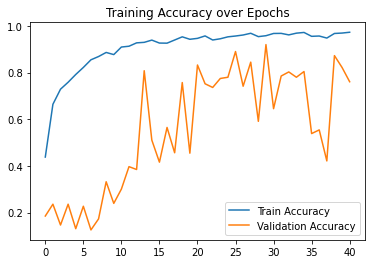

In [17]:
# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

# Plot accuracy trends
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Training Accuracy over Epochs")
plt.show()


In [18]:
# Predict on a test sample
sample = X_test[0].reshape(1, 200, 7)
prediction = model.predict(sample)
predicted_fault = np.argmax(prediction)

print(f"Predicted Fault Type: {predicted_fault}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Predicted Fault Type: 3


In [22]:
model.save("CSTR_fault_detection_final.h5")

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test).argmax(axis=1)
print(classification_report(y_test, y_pred))

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step
              precision    recall  f1-score   support

         0.0       0.87      0.91      0.89        43
         1.0       1.00      0.87      0.93        46
         2.0       1.00      1.00      1.00        47
         3.0       1.00      1.00      1.00        35
         4.0       1.00      1.00      1.00        54
         5.0       1.00      1.00      1.00        49
         6.0       0.93      1.00      0.96        41
         7.0       1.00      1.00      1.00        45
         8.0       0.59      0.98      0.74        45
         9.0       1.00      0.85      0.92        48
        10.0       1.00      0.83      0.91        30
        11.0       0.70      0.85      0.76        46
        12.0       0.59      0.23      0.33        43

    accuracy                           0.89       572
   macro avg       0.90      0.89      0.88       572
weighted avg       0.90      0.89      0.88       572



In [12]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0.0: 180, 1.0: 180, 2.0: 180, 3.0: 180, 4.0: 180, 5.0: 180, 6.0: 180, 7.0: 180, 8.0: 180, 9.0: 180, 10.0: 168, 11.0: 160, 12.0: 160}


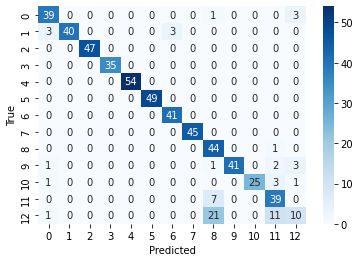

In [20]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()